In [7]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
import seaborn as sns, numpy as np
import functools
from scipy.spatial.distance import squareform
import math

### IMPORTS

In [8]:
from Inference.Variational import MeanFieldVariationalDistribution

In [9]:
class VariationalGenerativeNetwork(nn.Module):
    def __init__(self, nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(VariationalGenerativeNetwork, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma, device)
        self.nntransform = nntransform
        
          
    def sample(self, n=1):
        return self.nntransform(self.mfvar.sample(n))

In [10]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [11]:
# Find what device to work with
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda', index=2)

In [12]:
torch.set_default_dtype(torch.float64)

# Model principal

In [13]:
mixture = [torch.distributions.normal.Normal(torch.tensor(-4.5, device=device), torch.tensor(2.0, device=device)),
           torch.distributions.normal.Normal(torch.tensor(-2.0, device=device), torch.tensor(1.0, device=device)),
           torch.distributions.normal.Normal(torch.tensor(-4.0, device=device), torch.tensor(0.4, device=device)),
           torch.distributions.normal.Normal(torch.tensor(-1.0, device=device), torch.tensor(0.4, device=device)),
           torch.distributions.normal.Normal(torch.tensor(-0.5, device=device), torch.tensor(0.15, device=device)),
           torch.distributions.normal.Normal(torch.tensor(5.0, device=device), torch.tensor(0.25, device=device)),
           torch.distributions.normal.Normal(torch.tensor(5.5, device=device), torch.tensor(0.95, device=device))]
proportions = torch.tensor([0.28,0.3,0.02,0.03,0.03,0.17,0.17], device=device)

In [14]:
mixture = [torch.distributions.normal.Normal(torch.tensor(-3.5, device=device), torch.tensor(1.0, device=device)),
           torch.distributions.normal.Normal(torch.tensor(3.5, device=device), torch.tensor(1.0, device=device))]
proportions = torch.tensor([0.25,0.75], device=device)

In [539]:
#def logposterior(x):
#    v = [None]*len(mixture)
#    for j in range(len(mixture)):
#        v[j] = mixture[j].log_prob(x) + proportions[j].log()
#    return torch.logsumexp(torch.stack(v), dim=0)

In [540]:
#def logposterior(x):
#    return -x**8/4.0 - torch.tensor(2.2398542383262745).log()

In [15]:
beta = 1.5
mu = -6.0
def logposterior(x):
    z = (x-mu)/beta
    return -(z+torch.exp(-z)) - torch.tensor(beta).log()

In [16]:
#np.trapz(logposterior(x_lin).exp().squeeze().detach().cpu().numpy(), dx=0.01)

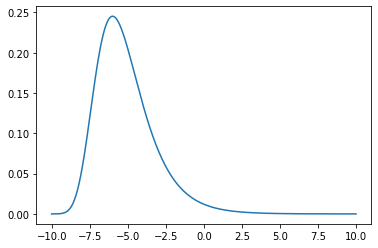

In [17]:
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1).to(device)
plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
plt.show()

# Modèle génératif: Hypernet autoencodeur

In [14]:
def LinSigmoid(x):
    return 1/(1+(math.e**-x)) + 0.05*x

In [15]:
def LinTanh(x):
    return torch.tanh(x) + 0.05*x

In [642]:
def LinELU(x):
    return torch.nn.functional.elu(x) + 0.01*x + 1.0

In [17]:
def RBF(x):
    return torch.exp(-x**2)

In [509]:
def RectifiedQuad(x):
    return nn.functional.relu(x)**2

In [616]:
def swish(x, beta = 1):
    return (x * torch.sigmoid(beta * x))

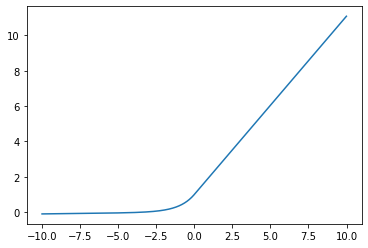

In [643]:
plt.plot(x_lin.detach().cpu().numpy(), LinELU(x_lin).detach().cpu().numpy())

In [18]:
class Net(nn.Module):
    def __init__(self,lat_dim, H):
        super(Net, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(H, H)
        self.L3 = nn.Linear(H, H)
        self.L4 = nn.Linear(H, 1)

    def forward(self, input):
        h = nn.functional.relu(self.L1(input))
        h = nn.functional.relu(self.L2(h))
        h = nn.functional.relu(self.L3(h))
        h = self.L4(h)
        return h
    
lat_dim = 10
H = 50
nntransform = Net(lat_dim,H)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        #torch.nn.init.normal_(m.bias, mean=0.0, std=0.2)
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

Parameter containing:
tensor([0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413], device='cuda:2')

In [675]:
class PolynomialNet(nn.Module):
    def __init__(self,lat_dim, H):
        super(PolynomialNet, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(2*H, H)
        self.L3 = nn.Linear(2*H, H)
        self.L4 = nn.Linear(2*H, 1)

    def forward(self, input):
        h = torch.cat([nn.functional.relu(self.L1(input)), nn.functional.relu(self.L1(input))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L2(h)), nn.functional.relu(self.L2(h))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L3(h)), nn.functional.relu(self.L3(h))**2], dim=1) 
        h = self.L4(h)
        return h
    
lat_dim = 10
H = 50
nntransform = PolynomialNet(lat_dim,H)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        #torch.nn.init.normal_(m.bias, mean=0.0, std=0.2)
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

Parameter containing:
tensor([0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413], device='cuda:2')

In [554]:
class DenseBlockEncoder(torch.nn.Module):
    def __init__(self, wSequence, activation):
        super().__init__()
        self.fullyConnectedList = nn.ModuleList()
        self.activation = activation
        for j in range(len(wSequence) - 1):
            self.fullyConnectedList.append(nn.Linear(sum(wSequence[:j + 1]), wSequence[j + 1]))

    def forward(self, *inputs):
        hidden, = inputs
        for j in range(len(self.fullyConnectedList) - 1):
            layer = self.fullyConnectedList[j]
            hidden = self.activation(torch.cat([layer(hidden), hidden], dim=1))
        layer = self.fullyConnectedList[-1]
        hidden = layer(hidden)
        return hidden

lat_dim = 10
H = 20
nntransform = DenseBlockEncoder([lat_dim,H,H,H,H,1], nn.functional.relu)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        #torch.nn.init.normal_(m.bias, mean=0.0, std=0.2)
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=5.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

Parameter containing:
tensor([4.9932, 4.9932, 4.9932, 4.9932, 4.9932, 4.9932, 4.9932, 4.9932, 4.9932,
        4.9932], device='cuda:2')

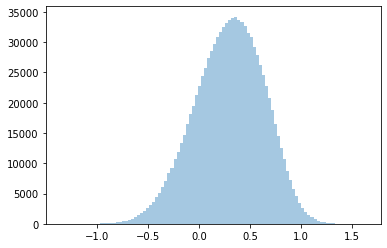

In [19]:
#x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
#plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
with torch.no_grad():
    X = q.sample(1000000)
ax = sns.distplot(X.detach().cpu().numpy(), bins=100, kde=False)

# Training #

In [21]:
N_ELBO = 1200

In [22]:
optimizer = torch.optim.Adagrad(q.parameters(), lr=0.01)

In [23]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.1)

In [24]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

In [25]:
%matplotlib inline
liveloss = PlotLosses()

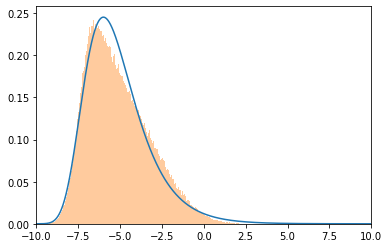

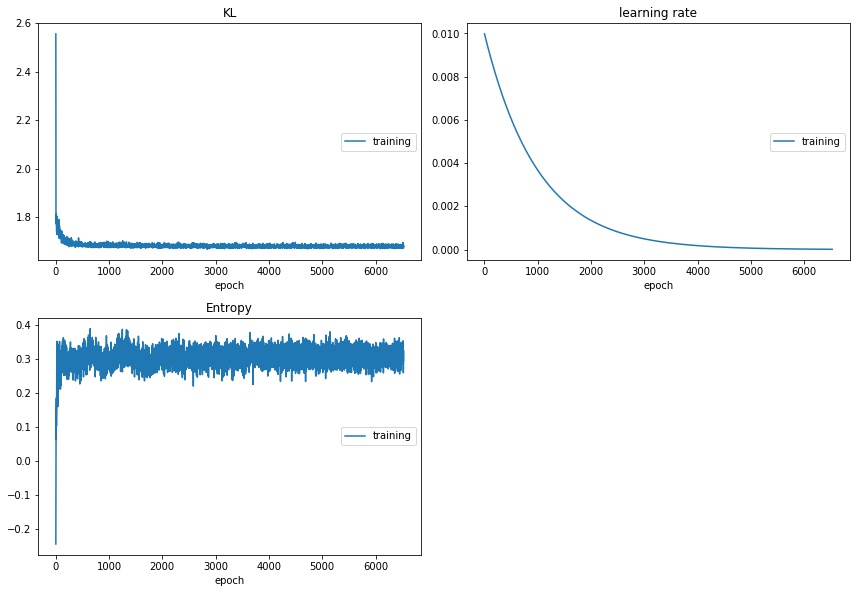

KL:
training   (min:    1.668, max:    5.956, cur:    1.679)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)

Entropy:
training   (min:   -1.335, max:    0.389, cur:    0.294)


KeyboardInterrupt: 

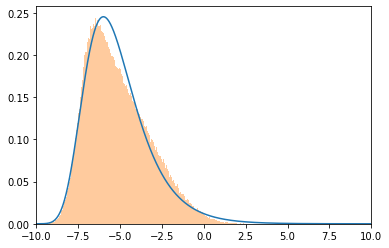

In [26]:
for t in range(100000):
    logs = {}
    optimizer.zero_grad()
    
    X = q.sample(N_ELBO)
    ExpectedPosterior = logposterior(X).mean()

    D = torch.nn.functional.pdist(X,p=2.0)
    #m = torch.zeros((N_ELBO-1, N_ELBO), device=device)
    #tril_indices = torch.tril_indices(row=N_ELBO, col=N_ELBO, offset=-1)
    #m[tril_indices[0]-1, tril_indices[1]] = D
    #m[tril_indices[1], tril_indices[0]] = D
    #(s,_) = torch.min(m,dim=0)
    #s = s[s>0.0]

    #Entropy = torch.mean(torch.log(s*torch.tensor(len(s),device=device).float())) \
    #        + torch.tensor(2.0, device=device).log() + torch.tensor(0.57721, device=device)
    
    Entropy = torch.log(D).mean()
    
    L = -ExpectedPosterior-Entropy
    
    if not torch.isfinite(L):
        break
    
    L.backward(retain_graph=True)
    torch.nn.utils.clip_grad_value_(q.parameters(), 0.1)
    
    optimizer.step()
    
    with torch.no_grad():
        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step() #L.detach().clone().cpu().numpy())

        logs['KL'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        logs['Entropy'] = Entropy.detach().clone().cpu().numpy()
        liveloss.update(logs)

        if t % 25 == 0:
            liveloss.draw()
            x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
            plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
            with torch.no_grad():
                X = q.sample(1000000)
            ax = sns.distplot(X.detach().cpu().numpy(), bins=1000, kde=False, norm_hist=True)
            ax.set_xlim(-10,10)

    if learning_rate < 0.00001:
        break

# Résultats #

In [ ]:
list(q.named_parameters())

In [ ]:
torch.sum(torch.log(s*N_ELBO))/N_ELBO 

In [ ]:
%matplotlib inline
with torch.no_grad():
    X = q.sample(1000000)
ax = sns.distplot(X.detach().numpy(), bins=100, kde=False)
ax.set_xlim(-10,10)

In [ ]:
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
plt.show()

In [ ]:
import math

In [ ]:
import math
def f(x):
    return torch.sin(x)+x

In [ ]:
%matplotlib inline

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), f(x_lin).detach().cpu().numpy())
plt.show()